In [1]:
import math
import os
import random
import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
import mglyph as mg
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF
from matplotlib import pyplot as plt
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import ImageReadMode

import mglyph_ml.lib as lib
from mglyph_ml.glyph_importer import GlyphImporter
from mglyph_ml.manifest_parsing import Manifest
from mglyph_ml.nn.glyph_dataset import GlyphDataset, GlyphSample

In [2]:
# here, we simply set up a glyph provider that out GlyphDataset will use to load glyphs from the export
train_glyphs = ["train-square.mglyph", "train-triangle.mglyph", "train-circle.mglyph"]
importers_train = [
    GlyphImporter(f"data/glyphs-experiment-1/{glyph}") for glyph in train_glyphs
]
dataset_train: GlyphDataset = GlyphDataset(*importers_train)

test_glyphs = ["test-square.mglyph", "test-triangle.mglyph", "test-circle.mglyph"]
importers_test = [
    GlyphImporter(f"data/glyphs-experiment-1/{glyph}") for glyph in test_glyphs
]
dataset_test: GlyphDataset = GlyphDataset(*importers_train)

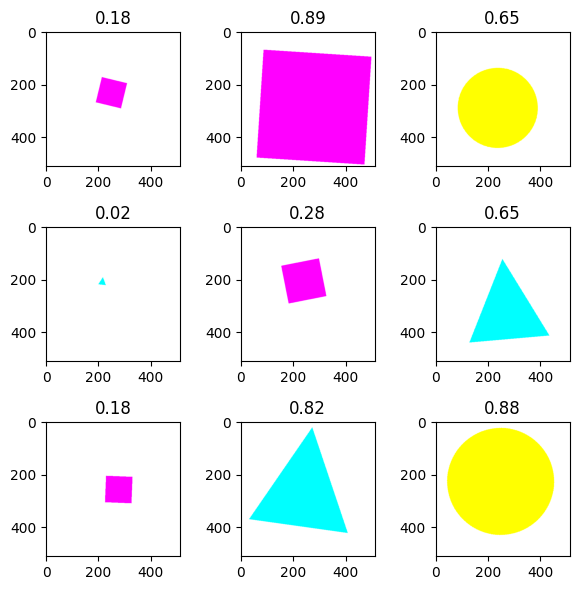

In [3]:
# we create a temporary dataset with normalization turned off so that we can see that is fed into the NN 
temp_dataset: GlyphDataset = GlyphDataset(*importers_train, normalize=False)
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for index, data in enumerate(temp_dataset.get_random_samples(n=9)):
    image, label = data
    # get row and column index for the subplot
    row = index // 3
    col = index % 3
    
    img = image.numpy().clip(0, 1).transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

    # display the image
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'{label:.2f}')

plt.tight_layout()
plt.show()

In [4]:
class GlyphRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: (batch, 3, 512, 512)
        # First conv: small kernel (3x3), shallow depth (4)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, padding=2)  # (3,512,512) -> (4,512,512)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # (4,512,512) -> (4,256,256)
        
        # Second conv: medium kernel (5x5), medium depth (8)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=9, padding=4)  # (4,256,256) -> (8,256,256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (8,256,256) -> (8,128,128)
        
        # Third conv: large kernel (7x7), deeper (16)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=15, padding=7)  # (8,128,128) -> (16,128,128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # (16,128,128) -> (16,64,64)
        
        # Reduce spatial size before FC to lower memory
        self.adaptivepool = nn.AdaptiveAvgPool2d((8, 8))  # (16,64,64) -> (16,8,8)
        
        # Flatten: 16*8*8 = 1024
        self.fc1 = nn.Linear(16 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # First conv block
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Second conv block
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Third conv block
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Final pooling and fully connected layers
        x = self.adaptivepool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# quick sanity check before training
# we check that the input data is of the expected shape and properly normalized
print("Sample image shape:", dataset_train[0][0])
print("Sample label:", dataset_train[0][1])

Sample image shape: tensor([[[0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         ...,
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664]],

        [[0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         ...,
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664]],

        [[0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
         [0.0664, 0.0664, 0.0664,  ...

In [6]:
def train_one_epoch(
    model: GlyphRegressor,
    train_data_loader: DataLoader,
    criterion,
    optimizer,
    epoch: int = 0
) -> float:
    model.train()
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(train_data_loader):
        inputs, labels = data
        # here, since we're training in batches, we sometimes get the output of the NN in
        # a Tensor that has this shape: [B, 1] (B - batch size)
        # we need to change the dimensions of the labels that get output from our dataloader
        # to also match the size, since our dataloader outputs them in the size [B].
        # -1 here tells torch to infer the last dimension from the other dimensions (in this
        # case, the other dimension is 1)
        labels = labels.view(-1, 1)

        # print(f"inputs size: {inputs.shape}")
        # print(f"Labels: {labels}")

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100  # loss per batch
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {last_loss:.3f}")
            running_loss = 0.0  # Reset after printing

    return last_loss

In [13]:
# next, we create the model
model = GlyphRegressor()

In [14]:
data_loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, )
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0003, momentum=0.00001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train for 5 epochs
for epoch in range(5):
    loss = train_one_epoch(model, data_loader_train, criterion, optimizer, epoch)
    if loss < 0.01:
        break

[1,   100] loss: 0.299
[1,   200] loss: 0.275
[1,   200] loss: 0.275
[1,   300] loss: 0.244
[1,   300] loss: 0.244
[1,   400] loss: 0.209
[1,   400] loss: 0.209
[1,   500] loss: 0.211
[1,   500] loss: 0.211
[1,   600] loss: 0.175
[1,   600] loss: 0.175
[2,   100] loss: 0.135
[2,   100] loss: 0.135
[2,   200] loss: 0.119
[2,   200] loss: 0.119
[2,   300] loss: 0.088
[2,   300] loss: 0.088
[2,   400] loss: 0.071
[2,   400] loss: 0.071
[2,   500] loss: 0.059
[2,   500] loss: 0.059
[2,   600] loss: 0.058
[2,   600] loss: 0.058
[3,   100] loss: 0.048
[3,   100] loss: 0.048
[3,   200] loss: 0.043
[3,   200] loss: 0.043
[3,   300] loss: 0.036
[3,   300] loss: 0.036
[3,   400] loss: 0.033
[3,   400] loss: 0.033
[3,   500] loss: 0.029
[3,   500] loss: 0.029
[3,   600] loss: 0.027
[3,   600] loss: 0.027
[4,   100] loss: 0.025
[4,   100] loss: 0.025
[4,   200] loss: 0.022
[4,   200] loss: 0.022
[4,   300] loss: 0.022
[4,   300] loss: 0.022
[4,   400] loss: 0.019
[4,   400] loss: 0.019
[4,   500] 

In [12]:
with torch.no_grad():
    # Generate 10 random indices from the test set
    random_indices = torch.randint(0, len(dataset_test), size=(10,)).tolist()
    for idx in random_indices:
        input, label = dataset_test[idx]
        # add batch dimension: (C,H,W) -> (1,C,H,W)
        img_batch = input.unsqueeze(0)
        pred = model(img_batch).item()
        print(f"True: {label * 100:.1f}, Predicted: {pred * 100:.1f}")
    print("=====train set======")
    random_indices = torch.randint(0, len(dataset_test), size=(10,)).tolist()
    for idx in random_indices:
        input, label = dataset_test[idx]
        # add batch dimension: (C,H,W) -> (1,C,H,W)
        img_batch = input.unsqueeze(0)
        pred = model(img_batch).item()
        print(f"True: {label * 100:.1f}, Predicted: {pred * 100:.1f}")

True: 37.2, Predicted: 39.3
True: 6.3, Predicted: 6.5
True: 7.0, Predicted: 10.1
True: 12.7, Predicted: 13.7
True: 99.6, Predicted: 87.3
True: 24.9, Predicted: 31.0
True: 22.0, Predicted: 20.9
True: 38.9, Predicted: 38.0
True: 80.2, Predicted: 83.2
True: 83.6, Predicted: 93.4
=====train set======
True: 87.4, Predicted: 96.2
True: 36.5, Predicted: 35.2
True: 69.7, Predicted: 82.2
True: 12.9, Predicted: 13.9
True: 30.9, Predicted: 34.7
True: 33.4, Predicted: 39.3
True: 10.6, Predicted: 13.9
True: 82.6, Predicted: 85.2
True: 67.2, Predicted: 71.9
True: 21.8, Predicted: 26.4
True: 12.9, Predicted: 13.9
True: 30.9, Predicted: 34.7
True: 33.4, Predicted: 39.3
True: 10.6, Predicted: 13.9
True: 82.6, Predicted: 85.2
True: 67.2, Predicted: 71.9
True: 21.8, Predicted: 26.4


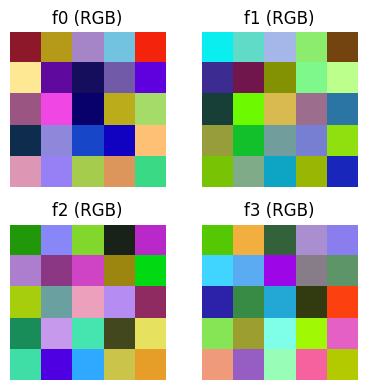

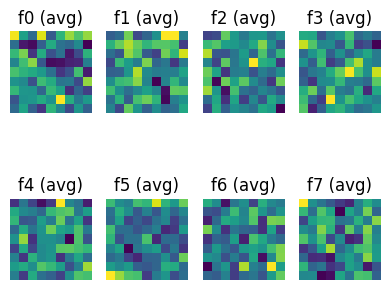

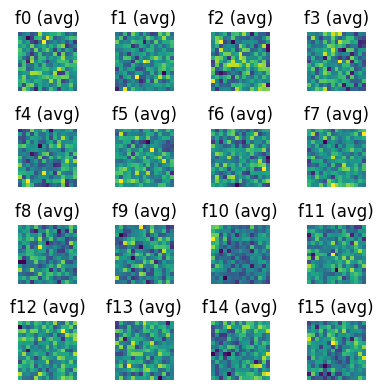

In [10]:
# here, we can analyze the model a little bit, see what it's doing internally
def visualize_kernels(model: torch.nn.Module, layer_name: str = "conv1", ncols: int = 8, figsize=(10,10), cmap="viridis"):
    """
    Visualize convolution kernels from `model.<layer_name>`.
    - If kernel has 3 input channels, shows as RGB.
    - Otherwise shows averaged (grayscale) kernel per output channel.
    """
    # get layer
    layer = getattr(model, layer_name, None)
    if layer is None:
        raise ValueError(f"Model has no attribute '{layer_name}'")

    weight = layer.weight.detach().cpu()  # shape: (out_ch, in_ch, kH, kW)
    out_ch, in_ch, kH, kW = weight.shape

    nrows = math.ceil(out_ch / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for i in range(nrows * ncols):
        ax = axes[i]
        ax.axis("off")
        if i >= out_ch:
            continue
        kern = weight[i]  # (in_ch, kH, kW)
        if in_ch == 3:
            # to H,W,C for display; normalize per-filter
            img = kern.permute(1, 2, 0).numpy()
            # normalize to 0..1
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            ax.imshow(img)
            ax.set_title(f"f{i} (RGB)")
        else:
            # average across input channels -> single plane
            img = kern.mean(dim=0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            ax.imshow(img, cmap=cmap)
            ax.set_title(f"f{i} (avg)")
    plt.tight_layout()
    return fig

# After training
fig1 = visualize_kernels(model, layer_name="conv1", ncols=2, figsize=(4,4))  # 4 kernels
plt.show()
fig2 = visualize_kernels(model, layer_name="conv2", ncols=4, figsize=(4,4))  # 8 kernels
plt.show()
fig3 = visualize_kernels(model, layer_name="conv3", ncols=4, figsize=(4,4))  # 16 kernels
plt.show()

In [11]:
import os
from PIL import Image
import numpy as np

def export_kernels(model: torch.nn.Module, layer_name: str, out_dir: str, cmap: str = "viridis"):
    """
    Export all kernels from a specified convolutional layer to images in `out_dir`.
    - If kernels have 3 input channels, saves as RGB images.
    - Otherwise, saves as grayscale images (averaged over input channels).
    """
    os.makedirs(out_dir, exist_ok=True)
    layer = getattr(model, layer_name, None)
    if layer is None:
        raise ValueError(f"Model has no attribute '{layer_name}'")
    weight = layer.weight.detach().cpu()  # (out_ch, in_ch, kH, kW)
    out_ch, in_ch, kH, kW = weight.shape
    for i in range(out_ch):
        kern = weight[i]  # (in_ch, kH, kW)
        if in_ch == 3:
            # RGB kernel: (3, kH, kW) -> (kH, kW, 3)
            img = kern.permute(1, 2, 0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            img = (img * 255).astype(np.uint8)
            im = Image.fromarray(img, mode="RGB")
        else:
            # Grayscale: average over input channels
            img = kern.mean(dim=0).numpy()
            mi, ma = img.min(), img.max()
            if ma - mi > 0:
                img = (img - mi) / (ma - mi)
            img = (img * 255).astype(np.uint8)
            im = Image.fromarray(img, mode="L")
        out_path = os.path.join(out_dir, f"{layer_name}_kernel_{i}.png")
        im.save(out_path)
    print(f"Exported {out_ch} kernels from '{layer_name}' to {out_dir}")

export_kernels(model=model, layer_name="conv3", out_dir="data/kernels")

Exported 16 kernels from 'conv3' to data/kernels
